# MADDPG with Cumulative Prospect Theory (CPT) in a First-Price Sealed-Bid Auction

## 1. Overview

This Python script implements the Multi-Agent Deep Deterministic Policy Gradient (MADDPG) algorithm to train agents participating in a simulated **first-price sealed-bid auction**. The core innovation is the integration of **Cumulative Prospect Theory (CPT)** to model the decision-making of a specific group of agents ("cpt_agents"). Unlike traditional reinforcement learning agents that maximize expected utility (or raw rewards), these CPT agents evaluate outcomes based on subjective utility functions and non-linear probability weighting, aiming for a more psychologically realistic bidding behavior. The script allows for a comparison between CPT-driven agents and standard DDPG agents within the same auction environment.

## 2. Environment: First-Price Sealed-Bid Auction

The script defines a custom multi-agent environment, `parallel_env`, that simulates a first-price sealed-bid auction:

* **Agents and Valuations:** Each agent receives a private valuation for an item, drawn uniformly from a range (e.g., [0, 100]). This valuation represents the true worth of the item to that agent.
* **Bidding:** Agents simultaneously submit sealed bids (actions). The observation for each agent is its own private valuation.
* **Winner Determination:** The agent with the highest bid wins the auction. Ties are broken by agent order.
* **Payoffs:**
    * **Winner:** The winner's reward is their private valuation minus their winning bid ($R_{\text{winner}} = V_i - B_i$).
    * **Losers:** Losers receive a reward of 0. (The script also contains commented-out logic for more complex loser penalties).
* **Single-Step Episodes:** Each auction (episode) consists of a single step: agents observe their valuations, submit bids, and receive rewards. The environment then resets with new valuations.
* **Agent Groups:** The environment supports different groups of agents (e.g., "cpt_agents" and "regular_agent"), allowing for heterogeneous agent populations.

## 3. Core Algorithm: MADDPG

The foundational reinforcement learning framework is **MADDPG**:

* **Actor-Critic Architecture:** Each agent has an actor (policy) network that maps its valuation (observation) to a bid (action), and a critic network that learns a Q-value function.
* **Centralized Critic, Decentralized Execution:** Critics may use global information during training, while actors act based on local observations.
* **Experience Replay & Soft Target Updates:** Standard DDPG components for stable learning.

## 4. Key Innovation: Cumulative Prospect Theory (CPT) Integration for "cpt_agents"

For agents designated as "cpt_agents", their learning process is modified by CPT principles, primarily affecting their actor (policy) network's loss function:

* **Utility Functions (`u_plus`, `u_minus`):** Global functions are defined to transform monetary outcomes (rewards) into subjective utilities.
    * `u_plus(x) = x^\alpha` for gains ($x \ge 0$).
    * `u_minus(x) = \lambda \cdot (-x)^\alpha$ for losses ($x < 0$).
    * These functions incorporate parameters for utility curvature (`alpha`) and loss aversion (`lambda`). *Note: While defined, their direct integration into the `compute_cpt_integral` function as currently used in the actor loss would require explicit transformation of `final_returns` before passing them to the integral.*
* **Piecewise Linear Probability Weighting Function (`w_approx_aux`, `w_approx`):**
    * Instead of using standard probability weighting formulas (like Prelec or Tversky-Kahneman), this script implements a flexible **piecewise linear probability weighting function**.
    * The function `w_approx_aux(L, x)` takes a list of parameters `L` and a probability `x` to return the decision weight $w(x)$.
    * The parameter list `L` defines the slopes, intercepts, and breakpoints of the linear segments: `L = [slope1, intercept1, ..., slope_n, intercept_n, breakpoint1, ..., breakpoint_{n-1}]`.
* **CPT Integral (`compute_cpt_integral`):**
    * This function calculates the CPT value of a lottery (distribution of outcomes). It takes a list of `trajectory_utilities` (in this context, the `final_returns` or episode rewards from the batch) and the probability weighting function parameters `w` (which is a tuple `(function_type, L_params)`).
    * It sorts the unique outcomes, segments them, and computes the integral by summing the products of (outcome differences) and (decision weights of exceeding those outcomes). This is a direct application of CPT valuation over the observed distribution of episode-end rewards.
* **Custom DDPG Loss (`CPTDDPGLoss` for "cpt_agents"):**
    * **Actor Loss (`loss_actor`):**
        * A `phi_factor` is computed by calling `compute_cpt_integral` with the `final_returns` (actual episode rewards of terminal states in the batch) and the predefined piecewise linear weighting function parameters `self.w`.
        * The actor's loss is then modified by this `phi_factor`. The script shows an exponential scaling: `loss_actor = - (torch.exp(beta * phi_factor) * Q_values).mean()`. This means the policy is updated to choose actions that lead to higher CPT-valued distributions of episode returns.
    * **Value Loss (`loss_value`):**
        * **Crucially, in the provided snippet, the critic for "cpt_agents" is trained using the standard DDPG target value.** The CPT transformation (`C_transform`) is defined but *not* applied to the `target_value` in the critic's loss calculation. This implies the critic for CPT agents learns to predict standard expected Q-values, while the actor's decisions are skewed by the CPT valuation of future return distributions.
* **Standard DDPG for "regular_agent":** Other agent groups (e.g., "regular_agent") use the standard `DDPGLoss` without CPT modifications, serving as a baseline.

## 5. Experimenting with CPT Hyperparameters

To explore different behavioral assumptions for CPT agents, you can adjust the following:

1.  **Utility Function Parameters (`alpha`, `lambda` in `u_plus`, `u_minus`):**
    * **`alpha` (Utility Curvature):**
        * `alpha = 1`: Risk-neutral (linear utility).
        * `0 < alpha < 1`: Risk-averse for gains, risk-seeking for losses (diminishing sensitivity).
        * `alpha > 1`: Risk-seeking for gains, risk-averse for losses.
    * **`lambda` (Loss Aversion in `u_minus`):**
        * `lambda > 1`: Loss-averse (losses feel larger than equivalent gains).
        * `lambda = 1`: No loss aversion.
    * **Note:** To make these parameters affect the `phi_factor` in the actor loss, you would need to modify the code to explicitly transform the `final_returns` using `u_plus` and `u_minus` *before* passing them to `compute_cpt_integral`.

2.  **Piecewise Linear Weighting Function Parameters (`L` for `w_approx`):**
    * This is the primary way to shape the probability perception of CPT agents in the current actor loss. The `L` parameter list is passed to `CPTDDPGLoss` during its initialization for the "cpt_agents" group:
        ```python
        loss_module = CPTDDPGLoss(
            # ...
            w=(0, [1.946..., 0., 0.696..., ..., 0.904...]) # The list is L_params
        )
        ```
    * **Structure of `L`:** `L = [s_1, i_1, s_2, i_2, ..., s_n, i_n, bp_1, bp_2, ..., bp_{n-1}]`
        * `s_k`, `i_k`: Slope and intercept of the k-th linear segment.
        * `bp_k`: The k-th breakpoint (probability value where the function changes slope). The segments are:
            * $[0, bp_1]$ uses $s_1 x + i_1$
            * $(bp_1, bp_2]$ uses $s_2 x + i_2$
            * ...
            * $(bp_{n-1}, 1]$ uses $s_n x + i_n$
    * **Experimentation:**
        * **Number of Segments:** Change `n` (implicitly by the length of `L`).
        * **Slopes and Intercepts:** Modify these to create different shapes:
            * Identity: `s_k=1, i_k=0` for all segments (linear probability weighting).
            * Overweighting small probabilities: Steeper slope near p=0.
            * Underweighting large probabilities: Flatter slope near p=1.
            * Inverse S-shape (common): Overweight small p, underweight large p.
        * **Breakpoints:** Shift these to change where the weighting behavior transitions.
        * Ensure $w(0)=0$ and $w(1)=1$ by setting intercepts and slopes appropriately (e.g., $i_1=0$, and $s_n \cdot 1 + i_n = 1$ if $bp_{n-1}$ is the last breakpoint before 1).

3.  **Beta in Actor Loss (`beta`):**
    * The `beta` parameter in `scale_factor = torch.exp(beta * phi_factor)` controls how strongly the CPT-valued `phi_factor` influences the Q-values in the actor's loss.
    * Higher `beta` means more sensitivity to the CPT valuation.
    * `beta = 0` would revert to standard DDPG actor loss (as `exp(0)=1`).

By systematically adjusting these parameters, particularly the `L` list for the weighting function, you can test how different CPT profiles affect bidding strategies, auction outcomes, and overall agent performance compared to standard rational agents.

## 6. Goal of the Code

This script aims to:

* Simulate a first-price auction with heterogeneous agents (CPT and standard DDPG).
* Investigate how agents with CPT-based decision-making, particularly with flexible piecewise linear probability weighting, behave in a competitive bidding environment.
* Compare the learning dynamics, bidding strategies, and economic outcomes (e.g., revenue, efficiency) of CPT agents versus traditional RL agents.
* Explore the impact of different CPT parameterizations (utility curvature, loss aversion, and especially the shape of the probability weighting function) on agent behavior.

In [ ]:
!pip3 install torchrl==0.6.0
!pip3 install vmas
!pip3 install pettingzoo[mpe]==1.24.3
!pip3 install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
!pip install torchrl==0.6.0 pettingzoo gymnasium torch tqdm

In [ ]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase, is_tensor_collection

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

try:
    is_sphinx = __sphinx_build__
except NameError:
    is_sphinx = False


try:
    from torch.compiler import is_compiling
except ImportError:
    from torch._dynamo import is_compiling


/usr/local/lib/python3.11/dist-packages/torchrl/data/replay_buffers/samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [ ]:
import functools, numpy as np, torch
from torch import nn
from gymnasium.spaces import Box
from gymnasium.utils import seeding

# PettingZoo API
from pettingzoo import ParallelEnv
from pettingzoo.utils import parallel_to_aec, wrappers

# TorchRL wrappers & collector
from torchrl.envs.libs.pettingzoo import PettingZooWrapper
from torchrl.envs.utils            import set_exploration_type, ExplorationType
from torchrl.collectors            import SyncDataCollector

# DDPG ingredients
from torchrl.objectives.ddpg import DDPGLoss
from torchrl.modules           import Actor, ValueOperator

In [ ]:
# Seed
seed = 0
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

# Sampling
frames_per_batch = 1000  # Number of team frames collected per sampling iteration
n_iters = 200  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters


# Replay buffer
memory_size = 1000000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 42  # Number of optimization steps per training iteration
train_batch_size = 256  # Number of frames trained in each optimiser step
lr = 1e-4  # Learning rate
max_grad_norm = 1 # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.01  # Tau for the soft-update of the target network


In [ ]:

def env(render_mode=None, group_config=None):
    """AEC‑style wrapper around our parallel_env, with optional custom groups."""
    aec = raw_env(render_mode=render_mode, group_config=group_config)
    if render_mode == "ansi":
        aec = wrappers.CaptureStdoutWrapper(aec)
    aec = wrappers.AssertOutOfBoundsWrapper(aec)
    aec = wrappers.OrderEnforcingWrapper(aec)
    return aec

def raw_env(render_mode=None, group_config=None):
    """Convert ParallelEnv → AEC via parallel_to_aec."""
    par = parallel_env(render_mode=render_mode, group_config=group_config)
    return parallel_to_aec(par)

class parallel_env(ParallelEnv):
    metadata = {"render_modes": ["human"]}

    def __init__(self,
             render_mode=None,
             max_bid: float = 100.0, # <-- Changed default max_bid to 100.0
             group_config: dict[str, int] | None = None):
      super().__init__()
      self.max_bid     = max_bid
      self.render_mode = render_mode

      # Default two groups of one agent each if none provided
      if group_config is None:
          group_config = {"regular_agent": 3, "cpt_agents": 0}

      # Build a flat agent → integer group_id map
      self.group_map = {}
      self.possible_agents = []
      for group_id, (group_name, size) in enumerate(group_config.items()):
          for i in range(size):
              agent = f"{group_name}_{i}"
              self.possible_agents.append(agent)
              self.group_map[agent] = group_id

      # Active agents; will be reset each episode
      self.agents = []

      # Observation space: valuation ∈ [0, 100]
      self.observation_spaces = {
          a: Box(0.0, 100.0, (1,), dtype=np.float32) # <-- Changed upper bound to 100.0
          for a in self.possible_agents
      }
      # Action space: bid ∈ [0, max_bid] (which is now 100 by default)
      self.action_spaces = {
          a: Box(0.0, float(self.max_bid), (1,), dtype=np.float32) # Uses self.max_bid
          for a in self.possible_agents
      }

      self.valuations = {}

    @functools.lru_cache(None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(None)
    def action_space(self, agent):
        return self.action_spaces[agent]

 # --- Inside the parallel_env class ---

# --- Inside the parallel_env class ---

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.np_random, _ = seeding.np_random(seed)

        # Activate all agents
        self.agents = self.possible_agents[:]

        # Sample private valuations U[0, 100]
        self.valuations = {
            # <-- Changed sampling range to 0-100
            a: float(self.np_random.uniform(0.0, 100.0))
            for a in self.agents
        }

        # Observation is the agent's valuation
        obs = {
            a: np.array([self.valuations[a]], dtype=np.float32)
            for a in self.agents
        }
        # Return only integer group_id in infos
        infos = {a: {"group_id": self.group_map[a]} for a in self.agents}

        return obs, infos

    def step(self, actions):
      """Handles one step of the auction environment."""
      if not actions:  # No bids submitted, end episode
          self.agents = []
          # Return empty dicts for observations, rewards, terminated, truncated, infos
          return {}, {}, {}, {}, {}

      # Extract float bids from action dictionary
      bids = {a: float(actions[a][0]) for a in actions}

      # Determine the winner (highest bid, ties broken by agent order)
      winner = max(self.possible_agents, key=lambda a: bids[a])
      winning_bid = bids[winner]

      # Initialize rewards dictionary
      rewards = {}
      # Define the minimum penalty (most negative value)
      min_penalty = -50

      # Calculate reward for each agent
      for agent in self.possible_agents:
          if agent == winner:
              # Winner's reward: valuation minus winning bid
              rewards[agent] = self.valuations[agent] - winning_bid
          else:
              # Loser's penalty calculation
              loser_bid = bids[agent]
              bid_difference = winning_bid - loser_bid

              # Determine the upper bound for the uniform distribution range.
              # It's the bid difference, but cannot be less (more negative)
              # than min_penalty to ensure low <= high.
              upper_bound = max(-50, -100)

              # Sample the penalty uniformly from [min_penalty, upper_bound)
              # using the environment's random number generator
              penalty = self.np_random.uniform(low=min_penalty, high=upper_bound)
              rewards[agent] = 0

    # Environment terminates after one step (auction)
      terminated = {a: True for a in self.possible_agents}
      truncated = {a: False for a in self.possible_agents} # Not using truncation

      # Next observation is typically zero or irrelevant as the episode ends
      # Although the env technically returns 0, the collector stores the *actual* next observation
      # which corresponds to the *new* valuation from the automatic reset.
      next_obs = {
          a: np.zeros((1,), dtype=np.float32) # This might be misleading, check collector behavior
          for a in self.possible_agents
      }

      # Include group info for multi-agent setup
      infos = {a: {"group_id": self.group_map[a]} for a in self.possible_agents}

      # Clear active agents as the episode ends
      self.agents = []

      # Return results
      return next_obs, rewards, terminated, truncated, infos


    def render(self):
        if self.render_mode == "human":
            print("Valuations:", self.valuations)

    def close(self):
        pass

In [ ]:
max_steps = 100  # Environment steps before done

n_agents = 2
n_landmarks = 1

use_vmas = False  # Set this to True for a great performance speedup

if not use_vmas:
    par = parallel_env(max_bid=100.0, render_mode=None) # <-- Pass max_bid=10.0

    # Wrap it with PettingZooWrapper as before
    base_env = PettingZooWrapper(
        env               = par,
        return_state      = False,
        use_mask          = False,
        categorical_actions = False,
        seed              = 42,
        device            = device,
        done_on_any       = True,
    )

else:
    num_vmas_envs = (
        frames_per_batch // max_steps
    )
    base_env = VmasEnv(
        scenario="simple_spread",
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        local_ratio=0.5,
        device=device,
        seed=seed,
        n_agents = n_agents
    )

In [ ]:
print(f"group_map: {base_env.group_map}")


group_map: {'regular_agent': ['regular_agent_0', 'regular_agent_1', 'regular_agent_2']}


In [ ]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)


action_spec: Composite(
    regular_agent: Composite(
        action: BoundedContinuous(
            shape=torch.Size([3, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([3])),
    device=cuda:0,
    shape=torch.Size([]))
reward_spec: Composite(
    regular_agent: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([3, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.flo

In [ ]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)


action_keys: [('regular_agent', 'action')]
reward_keys: [('regular_agent', 'reward')]
done_keys: ['done', 'terminated', 'truncated', ('regular_agent', 'done'), ('regular_agent', 'terminated'), ('regular_agent', 'truncated')]


In [ ]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)


In [ ]:
check_env_specs(env)


2025-04-22 13:52:34,185 [torchrl][INFO] check_env_specs succeeded!


In [ ]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)


rollout of 5 steps: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                regular_agent: TensorDict(
                    fields={
                        done: Tensor(shape=torch.Size([1, 3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                        episode_reward: Tensor(shape=torch.Size([1, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        info: TensorDict(
                            fields={
                                group_id: Tensor(shape=torch.Size([1, 3]), device=cuda:0, dtype=torch.float32, is_shared=True)},
                            batch_size=torch.Size([1, 3]),
                            device=cuda:0,
                            is_shared=True),
                        observatio

In [ ]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = False  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module


In [ ]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec[group, "action"].space.low,
            "high": env.full_action_spec[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy


In [ ]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.4,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy


In [ ]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence


In [ ]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )


Running value and policy for group 'regular_agent': TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        regular_agent: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                info: TensorDict(
                    fields={
                        group_id: Tensor(shape=torch.Size([3]), device=cuda:0, dtype=torch.float32, is_shared=True)},
                    batch_size=torch.Size([3]),
                    device=cuda:0,
                    is_shared=True),
                obs_action: Tensor(shape=torch.Size([3, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observati

In [ ]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)


In [ ]:
#Standard in off policy algos for efficient data collections
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(memory_size, device="cpu"),
        sampler=RandomSampler(),
        batch_size=train_batch_size,
    )
    replay_buffer.append_transform(lambda batch: batch.to(device))
    replay_buffers[group] = replay_buffer


In [ ]:
w_plus_prime_const = 0.2
w_minus_prime_const = 0.8

def u_plus(x):
    alpha = 0.7
    return torch.pow(x, alpha)

def u_minus(x):
    alpha = 0.95
    lam = 2.5
    return lam * torch.pow(-x, alpha)

def w_plus_prime(p):
    eta = 0.61
    return eta * torch.pow(p, eta - 1)

def w_minus_prime(p):
    eta = 0.69
    return eta * torch.pow(p, eta - 1)

def compute_phi_linear(R):
    """
    Compute linearized CPT sensitivity:
    φ(R) ≈ w'_+(p*) * u^+(R) for R>=0, and -w'_-(p*) * u^-(R) for R<0.
    """
    R = R.view(-1)
    v = torch.where(R >= 0, u_plus(R), -u_minus(R))
    phi = torch.where(R >= 0, w_plus_prime_const * v, -w_minus_prime_const * v)
    return phi.mean()

def C_transform(x):
    """
    Simple CPT transformation on one-step return:
    C(x) ≈ w'_+(p*) * u^+(x) if x >= 0, else -w'_-(p*) * u^-(x).
    """
    return torch.where(x >= 0, w_plus_prime_const * u_plus(x), -w_minus_prime_const * u_minus(x))

def w_approx_aux(L,x):
    n = (len(L)+1)//3
    breaking_points = L[2*n:]
    for i, elt in enumerate(breaking_points):
        if x < elt:
            return L[2*i]*x + L[2*i+1]
    i = n-1
    return L[2*i]*x + L[2*i+1]
def w_approx(L):
    return (lambda x:w_approx_aux(L,x))


def compute_cpt_integral(trajectory_utilities, w, batch_size):
    """
    Compute the CPT integral using piecewise integration.

    Args:
        trajectory_utilities: a list or 1D tensor of utility values (episode returns).
        w: a tuple (function_type, parameters) that defines the weighting function.
           (We assume that a function w_approx(parameters) is available.)
        batch_size: the number of trajectories in the batch.

    Returns:
        The estimated CPT value (a float).
    """
    # Convert to a list of floats if necessary.
    if torch.is_tensor(trajectory_utilities):
        utilities = trajectory_utilities.tolist()
    else:
        utilities = [float(x) for x in trajectory_utilities]

    # Determine segmentation points (include 0 plus unique outcomes).
    segments = sorted(list(set(utilities + [0])))

    # Create segments for gains (non-negative) and losses (non-positive)
    positive_segments = sorted([x for x in segments if x >= 0])
    negative_segments = sorted([-x for x in segments if x <= 0])

    res = 0
    if len(segments) == 0:
        return 0
    parameters = w[1]  # extract the parameter list from the tuple

    # Integral over gains
    for i in range(len(positive_segments) - 1):
        count = sum(1 for x in utilities if x > positive_segments[i])
        weight = w_approx(parameters)(count / batch_size)
        res += weight * (positive_segments[i+1] - positive_segments[i])

    # Integral over losses
    for i in range(len(negative_segments) - 1):
            # Calculate probability P(X <= -z_i) where z_i = negative_segments[i]
            # Note: x <= -negative_segments[i] is equivalent to -x >= negative_segments[i]
            count_le = sum(1 for x in utilities if x <= -negative_segments[i])
            prob_le = count_le / batch_size
            # Apply the weighting function w^- (assuming w_approx is w^- or handles it)
            weight = w_approx(parameters)(prob_le) # Corrected weight calculation
            res -= weight * (negative_segments[i+1] - negative_segments[i])

    return torch.tensor(res, dtype=torch.float32, device=device)


In [ ]:
from __future__ import annotations

from copy import deepcopy
from dataclasses import dataclass
from typing import Tuple

import torch
from tensordict import TensorDict, TensorDictBase, TensorDictParams
from tensordict.nn import dispatch, TensorDictModule

from tensordict.utils import NestedKey, unravel_key
from torchrl.modules.tensordict_module.actors import ActorCriticWrapper
from torchrl.objectives.common import LossModule
from torchrl.objectives.utils import (
    _cache_values,
    _GAMMA_LMBDA_DEPREC_ERROR,
    _reduce,
    default_value_kwargs,
    distance_loss,
    ValueEstimators,
)
from torchrl.objectives.value import TD0Estimator, TD1Estimator, TDLambdaEstimator


class CPTDDPGLoss(LossModule):
    """The DDPG Loss class.

    Args:
        actor_network (TensorDictModule): a policy operator.
        value_network (TensorDictModule): a Q value operator.
        loss_function (str): loss function for the value discrepancy. Can be one of "l1", "l2" or "smooth_l1".
        delay_actor (bool, optional): whether to separate the target actor networks from the actor networks used for
            data collection. Default is ``False``.
        delay_value (bool, optional): whether to separate the target value networks from the value networks used for
            data collection. Default is ``True``.
        separate_losses (bool, optional): if ``True``, shared parameters between
            policy and critic will only be trained on the policy loss.
            Defaults to ``False``, i.e., gradients are propagated to shared
            parameters for both policy and critic losses.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``"none"`` | ``"mean"`` | ``"sum"``. ``"none"``: no reduction will be applied,
            ``"mean"``: the sum of the output will be divided by the number of
            elements in the output, ``"sum"``: the output will be summed. Default: ``"mean"``.

    Examples:
        >>> import torch
        >>> from torch import nn
        >>> from torchrl.data import Bounded
        >>> from torchrl.modules.tensordict_module.actors import Actor, ValueOperator
        >>> from torchrl.objectives.ddpg import DDPGLoss
        >>> from tensordict import TensorDict
        >>> n_act, n_obs = 4, 3
        >>> spec = Bounded(-torch.ones(n_act), torch.ones(n_act), (n_act,))
        >>> actor = Actor(spec=spec, module=nn.Linear(n_obs, n_act))
        >>> class ValueClass(nn.Module):
        ...     def __init__(self):
        ...         super().__init__()
        ...         self.linear = nn.Linear(n_obs + n_act, 1)
        ...     def forward(self, obs, act):
        ...         return self.linear(torch.cat([obs, act], -1))
        >>> module = ValueClass()
        >>> value = ValueOperator(
        ...     module=module,
        ...     in_keys=["observation", "action"])
        >>> loss = DDPGLoss(actor, value)
        >>> batch = [2, ]
        >>> data = TensorDict({
        ...        "observation": torch.randn(*batch, n_obs),
        ...        "action": spec.rand(batch),
        ...        ("next", "done"): torch.zeros(*batch, 1, dtype=torch.bool),
        ...        ("next", "terminated"): torch.zeros(*batch, 1, dtype=torch.bool),
        ...        ("next", "reward"): torch.randn(*batch, 1),
        ...        ("next", "observation"): torch.randn(*batch, n_obs),
        ...    }, batch)
        >>> loss(data)
        TensorDict(
            fields={
                loss_actor: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                loss_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                pred_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                pred_value_max: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                target_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                target_value_max: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False)

    This class is compatible with non-tensordict based modules too and can be
    used without recurring to any tensordict-related primitive. In this case,
    the expected keyword arguments are:
    ``["next_reward", "next_done", "next_terminated"]`` + in_keys of the actor_network and value_network.
    The return value is a tuple of tensors in the following order:
    ``["loss_actor", "loss_value", "pred_value", "target_value", "pred_value_max", "target_value_max"]``

    Examples:
        >>> import torch
        >>> from torch import nn
        >>> from torchrl.data import Bounded
        >>> from torchrl.modules.tensordict_module.actors import Actor, ValueOperator
        >>> from torchrl.objectives.ddpg import DDPGLoss
        >>> _ = torch.manual_seed(42)
        >>> n_act, n_obs = 4, 3
        >>> spec = Bounded(-torch.ones(n_act), torch.ones(n_act), (n_act,))
        >>> actor = Actor(spec=spec, module=nn.Linear(n_obs, n_act))
        >>> class ValueClass(nn.Module):
        ...     def __init__(self):
        ...         super().__init__()
        ...         self.linear = nn.Linear(n_obs + n_act, 1)
        ...     def forward(self, obs, act):
        ...         return self.linear(torch.cat([obs, act], -1))
        >>> module = ValueClass()
        >>> value = ValueOperator(
        ...     module=module,
        ...     in_keys=["observation", "action"])
        >>> loss = DDPGLoss(actor, value)
        >>> loss_actor, loss_value, pred_value, target_value, pred_value_max, target_value_max = loss(
        ...     observation=torch.randn(n_obs),
        ...     action=spec.rand(),
        ...     next_done=torch.zeros(1, dtype=torch.bool),
        ...     next_terminated=torch.zeros(1, dtype=torch.bool),
        ...     next_observation=torch.randn(n_obs),
        ...     next_reward=torch.randn(1))
        >>> loss_actor.backward()

    The output keys can also be filtered using the :meth:`DDPGLoss.select_out_keys`
    method.

    Examples:
        >>> loss.select_out_keys('loss_actor', 'loss_value')
        >>> loss_actor, loss_value = loss(
        ...     observation=torch.randn(n_obs),
        ...     action=spec.rand(),
        ...     next_done=torch.zeros(1, dtype=torch.bool),
        ...     next_terminated=torch.zeros(1, dtype=torch.bool),
        ...     next_observation=torch.randn(n_obs),
        ...     next_reward=torch.randn(1))
        >>> loss_actor.backward()

    """

    @dataclass
    class _AcceptedKeys:
        """Maintains default values for all configurable tensordict keys.

        This class defines which tensordict keys can be set using '.set_keys(key_name=key_value)' and their
        default values.

        Attributes:
            state_action_value (NestedKey): The input tensordict key where the
                state action value is expected. Will be used for the underlying
                value estimator as value key. Defaults to ``"state_action_value"``.
            priority (NestedKey): The input tensordict key where the target
                priority is written to. Defaults to ``"td_error"``.
            reward (NestedKey): The input tensordict key where the reward is expected.
                Will be used for the underlying value estimator. Defaults to ``"reward"``.
            done (NestedKey): The key in the input TensorDict that indicates
                whether a trajectory is done. Will be used for the underlying value estimator.
                Defaults to ``"done"``.
            terminated (NestedKey): The key in the input TensorDict that indicates
                whether a trajectory is terminated. Will be used for the underlying value estimator.
                Defaults to ``"terminated"``.

        """

        state_action_value: NestedKey = "state_action_value"
        priority: NestedKey = "td_error"
        reward: NestedKey = "reward"
        done: NestedKey = "done"
        terminated: NestedKey = "terminated"

    tensor_keys: _AcceptedKeys
    default_keys = _AcceptedKeys
    default_value_estimator: ValueEstimators = ValueEstimators.TD0
    out_keys = [
        "loss_actor",
        "loss_value",
        "pred_value",
        "target_value",
        "pred_value_max",
        "target_value_max",
    ]

    actor_network: TensorDictModule
    value_network: actor_network
    actor_network_params: TensorDictParams
    value_network_params: TensorDictParams
    target_actor_network_params: TensorDictParams
    target_value_network_params: TensorDictParams

    def __init__(
        self,
        actor_network: TensorDictModule,
        value_network: TensorDictModule,
        *,
        loss_function: str = "l2",
        delay_actor: bool = False,
        delay_value: bool = True,
        gamma: float = None,
        separate_losses: bool = False,
        reduction: str = None,
        w: tuple = None
    ) -> None:
        self.w = w
        self._in_keys = None
        if reduction is None:
            reduction = "mean"
        super().__init__()
        self.delay_actor = delay_actor
        self.delay_value = delay_value

        actor_critic = ActorCriticWrapper(actor_network, value_network)
        params = TensorDict.from_module(actor_critic)
        params_meta = params.apply(
            self._make_meta_params, device=torch.device("meta"), filter_empty=False
        )
        with params_meta.to_module(actor_critic):
            self.__dict__["actor_critic"] = deepcopy(actor_critic)

        self.convert_to_functional(
            actor_network,
            "actor_network",
            create_target_params=self.delay_actor,
        )
        if separate_losses:
            # we want to make sure there are no duplicates in the params: the
            # params of critic must be refs to actor if they're shared
            policy_params = list(actor_network.parameters())
        else:
            policy_params = None
        self.convert_to_functional(
            value_network,
            "value_network",
            create_target_params=self.delay_value,
            compare_against=policy_params,
        )
        self.actor_critic.module[0] = self.actor_network
        self.actor_critic.module[1] = self.value_network

        self.actor_in_keys = actor_network.in_keys
        self.value_exclusive_keys = set(self.value_network.in_keys) - (
            set(self.actor_in_keys) | set(self.actor_network.out_keys)
        )

        self.loss_function = loss_function
        self.reduction = reduction
        if gamma is not None:
            raise TypeError(_GAMMA_LMBDA_DEPREC_ERROR)

    def _forward_value_estimator_keys(self, **kwargs) -> None:
        if self._value_estimator is not None:
            self._value_estimator.set_keys(
                value=self._tensor_keys.state_action_value,
                reward=self._tensor_keys.reward,
                done=self._tensor_keys.done,
                terminated=self._tensor_keys.terminated,
            )
        self._set_in_keys()

    def _set_in_keys(self):
        in_keys = {
            unravel_key(("next", self.tensor_keys.reward)),
            unravel_key(("next", self.tensor_keys.done)),
            unravel_key(("next", self.tensor_keys.terminated)),
            *self.actor_in_keys,
            *[unravel_key(("next", key)) for key in self.actor_in_keys],
            *self.value_network.in_keys,
            *[unravel_key(("next", key)) for key in self.value_network.in_keys],
        }
        self._in_keys = sorted(in_keys, key=str)

    @property
    def in_keys(self):
        if self._in_keys is None:
            self._set_in_keys()
        return self._in_keys

    @in_keys.setter
    def in_keys(self, values):
        self._in_keys = values


    def _clear_weakrefs(self, *tds):
        if is_compiling():
            # Waiting for weakrefs reconstruct to be supported by compile
            for td in tds:
                if isinstance(td, str):
                    td = getattr(self, td, None)
                if not is_tensor_collection(td):
                    continue
                td.clear_refs_for_compile_()

    @dispatch
    def forward(self, tensordict: TensorDictBase) -> TensorDict:
        """Computes the DDPG losses given a tensordict sampled from the replay buffer.

        This function will also write a "td_error" key that can be used by prioritized replay buffers to assign
            a priority to items in the tensordict.

        Args:
            tensordict (TensorDictBase): a tensordict with keys ["done", "terminated", "reward"] and the in_keys of the actor
                and value networks.

        Returns:
            a tuple of 2 tensors containing the DDPG loss.

        """
        loss_value, metadata = self.loss_value(tensordict)
        loss_actor, metadata_actor = self.loss_actor(tensordict)
        metadata.update(metadata_actor)
        td_out = TensorDict(
            source={"loss_actor": loss_actor, "loss_value": loss_value, **metadata},
            batch_size=[],
        )
        self._clear_weakrefs(
            tensordict,
            td_out,
            "value_network_params",
            "target_value_network_params",
            "target_actor_network_params",
            "actor_network_params",
        )
        return td_out

    def loss_actor(self, tensordict: TensorDictBase) -> Tuple[torch.Tensor, dict]:
        """Compute the CPT-modified actor loss."""

        td_copy = tensordict.select(
            *self.actor_in_keys, *self.value_exclusive_keys, strict=False
        ).detach()

        with self.actor_network_params.to_module(self.actor_network):
            td_copy = self.actor_network(td_copy)

        with self._cached_detached_value_params.to_module(self.value_network):
            td_copy = self.value_network(td_copy)

        # Get action chosen by policy: μ(o)
        actions = td_copy.get((self.actor_network.in_keys[0][0], "action"))

        Q_values = td_copy.get(self.tensor_keys.state_action_value).squeeze(-1)

        # --- Corrected CPT phi_factor Calculation ---
        group = self.actor_network.in_keys[0][0]
        # Identify terminal steps in the 'next' state within the batch
        # Make sure 'done' and 'episode_reward' exist under the 'next' key for the group
        next_done_key = ("next", group, "done")
        next_reward_key = ("next", group, "episode_reward")

        if next_done_key not in tensordict.keys(include_nested=True) or \
           next_reward_key not in tensordict.keys(include_nested=True):
             # Handle case where keys might be missing (e.g., if process_batch wasn't perfect)
             # Option 1: Default to neutral phi_factor
             phi_factor = torch.tensor(1.0, device=tensordict.device)
             print(f"Warning: Missing required keys for phi_factor calculation in group {group}. Defaulting phi_factor to 1.0.")
             # Option 2: Raise an error
             # raise KeyError(f"Keys {next_done_key} or {next_reward_key} not found in tensordict.")
        else:
            terminal_mask = tensordict.get(next_done_key).squeeze(-1) # Shape: [batch_size]
            # Get episode rewards corresponding to these terminal 'next' states
            final_returns = tensordict.get(next_reward_key)[terminal_mask].view(-1)

            if final_returns.numel() > 1: # Need at least a few samples for meaningful integral
                phi_factor = compute_cpt_integral(final_returns, self.w, final_returns.numel())
                # Optional: Add some clamping or smoothing if phi_factor becomes extreme
                # phi_factor = torch.clamp(phi_factor, -10.0, 10.0)
            else:
                # Not enough terminal samples in this batch, default to neutral
                phi_factor = torch.tensor(1.0, device=tensordict.device)
                # You could also use a running average phi_factor here if needed

        # --- End Corrected Calculation ---

        # --- Revised Actor Loss Calculation ---
        # # Option A: Direct Scaling (Use signed phi_factor, might be unstable)
        # loss_actor = - (phi_factor * Q_values).mean()

        # Option B: Exponential Scaling (Recommended for Stability)
        beta = 1.0 # Tune this hyperparameter
        scale_factor = torch.exp(beta * phi_factor)
        loss_actor = - (scale_factor * Q_values).mean()
        # --- End Revised Actor Loss ---

        # Ensure loss is a scalar
        loss_actor = _reduce(loss_actor, self.reduction)

        # Keep metadata empty for now, or add relevant info like phi_factor
        metadata_actor = {"phi_factor": phi_factor.detach().item()}
        return loss_actor, metadata_actor # Return scalar loss and metadata dict

    def loss_value(self, tensordict: TensorDictBase) -> Tuple[torch.Tensor, dict]:
        """Compute the CPT-modified critic loss."""
        td_copy = tensordict.select(*self.value_network.in_keys, strict=False).detach()
        with self.value_network_params.to_module(self.value_network):
            self.value_network(td_copy)
        pred_val = td_copy.get(self.tensor_keys.state_action_value).squeeze(-1)

        # Standard target value calculation
        target_value = self.value_estimator.value_estimate(
            tensordict, target_params=self._cached_target_params
        ).squeeze(-1)

        # Apply CPT transformation
        # target_value_CPT = C_transform(target_value)

        # Compute CPT critic loss
        loss_value = distance_loss(pred_val, target_value, loss_function=self.loss_function)

        # Update tensor dictionary with CPT-transformed target
        tensordict.set("target_value", target_value, inplace=True)

        # Compute TD error for prioritized replay buffer
        td_error = (pred_val - target_value).pow(2).detach()
        tensordict.set(self.tensor_keys.priority, td_error, inplace=True)

        metadata = {
            "td_error": td_error,
            "pred_value": pred_val,
            "target_value": target_value,
        }
        return _reduce(loss_value, self.reduction), metadata

    def make_value_estimator(self, value_type: ValueEstimators = None, **hyperparams):
        if value_type is None:
            value_type = self.default_value_estimator
        self.value_type = value_type
        hp = dict(default_value_kwargs(value_type))
        if hasattr(self, "gamma"):
            hp["gamma"] = self.gamma
        hp.update(hyperparams)
        if value_type == ValueEstimators.TD1:
            self._value_estimator = TD1Estimator(value_network=self.actor_critic, **hp)
        elif value_type == ValueEstimators.TD0:
            self._value_estimator = TD0Estimator(value_network=self.actor_critic, **hp)
        elif value_type == ValueEstimators.GAE:
            raise NotImplementedError(
                f"Value type {value_type} it not implemented for loss {type(self)}."
            )
        elif value_type == ValueEstimators.TDLambda:
            self._value_estimator = TDLambdaEstimator(
                value_network=self.actor_critic, **hp
            )
        else:
            raise NotImplementedError(f"Unknown value type {value_type}")

        tensor_keys = {
            "value": self.tensor_keys.state_action_value,
            "reward": self.tensor_keys.reward,
            "done": self.tensor_keys.done,
            "terminated": self.tensor_keys.terminated,
        }
        self._value_estimator.set_keys(**tensor_keys)

    @property
    @_cache_values
    def _cached_target_params(self):
        target_params = TensorDict(
            {
                "module": {
                    "0": self.target_actor_network_params,
                    "1": self.target_value_network_params,
                }
            },
            batch_size=self.target_actor_network_params.batch_size,
            device=self.target_actor_network_params.device,
        )
        return target_params

    @property
    @_cache_values
    def _cached_detached_value_params(self):
        return self.value_network_params.detach()


In [ ]:
losses = {}
for group, agents in env.group_map.items():   # group is e.g. "cpt_agents" or "regular_agent"
    if group == "cpt_agents":
        # CPT version
        loss_module = CPTDDPGLoss(
            actor_network=policies[group],
            value_network=critics[group],
            delay_value=True,
            loss_function="l2",
            w=(0, [1.94671279, 0., 0.69678392, 0.11132902,
                   2.70977837, -1.70977837, 0.08906833, 0.90467621])
        )
    else:
        # Standard DDPG
        loss_module = DDPGLoss(
            actor_network=policies[group],
            value_network=critics[group],
            delay_value=True,
            loss_function="l2"
        )

    # common configuration
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

# Soft‑update targets for each group
target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau)
    for group, loss in losses.items()
}

# Separate optimisers for actor & critic per group
optimisers = {}
for group, loss in losses.items():
    optimisers[group] = {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }



In [ ]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch


In [ ]:
# --- Initialization for Logging ---
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
agent_reward_hist = { agent: [] for agent in env.possible_agents }
agent_actor_loss = {agent: [] for agent in env.possible_agents}
agent_value_loss = {agent: [] for agent in env.possible_agents}
agent_phi_hist   = {agent: [] for agent in env.possible_agents}
agent_bid_hist = {agent: [] for agent in env.possible_agents}
agent_valuation_hist = {agent: [] for agent in env.possible_agents} # <-- ADDED: Initialize valuation history dict

train_group_map = copy.deepcopy(env.group_map)

grad_norms = []
# --- Training/collection iterations ---
for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)  # Util to expand done keys if needed

    # --- Store bids and valuations from the current batch ---
    for group, agents in env.group_map.items():
        # Action tensor shape: [frames_per_batch, num_agents_in_group, action_dim]
        actions_tensor = batch.get((group, "action"))
        # Observation tensor shape: [frames_per_batch, num_agents_in_group, obs_dim]
        observations_tensor = batch.get((group, "observation")) # Observation is the valuation

        # Reshape if necessary (e.g., if collector returns nested batch dims)
        if actions_tensor.dim() > 3: # Example check, adjust if needed
            actions_tensor = actions_tensor.reshape(-1, len(agents), actions_tensor.shape[-1])
        if observations_tensor.dim() > 3:
            observations_tensor = observations_tensor.reshape(-1, len(agents), observations_tensor.shape[-1])

        # Calculate mean bid and valuation over the batch dimension for this iteration
        mean_bids_this_iter = actions_tensor.mean(dim=0) # Shape: [num_agents_in_group, action_dim]
        mean_vals_this_iter = observations_tensor.mean(dim=0) # Shape: [num_agents_in_group, obs_dim]

        for agent_idx, agent_name in enumerate(agents):
             # Append the mean bid for this agent from this iteration
             agent_bid_hist[agent_name].append(mean_bids_this_iter[agent_idx, 0].item())
             # Append the mean valuation for this agent from this iteration
             agent_valuation_hist[agent_name].append(mean_vals_this_iter[agent_idx, 0].item())
    # --- End storing bids and valuations ---


    # --- Optimization Loop ---
    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )  # Exclude data from other groups
        group_batch = group_batch.reshape(
            -1
        )  # This just affects the leading dimensions in batch_size of the tensordict
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()
            loss_vals = losses[group](subdata)

            # Store agent-specific losses and phi factor
            for agent in env.group_map[group]:
              agent_actor_loss[agent].append( loss_vals["loss_actor"].item() )
              agent_value_loss[agent].append( loss_vals["loss_value"].item() )
              phi_factor_item = loss_vals.get("phi_factor", None) # Get phi_factor if available
              if phi_factor_item is not None:
                  # Ensure it's a scalar before appending
                  agent_phi_hist[agent].append(phi_factor_item) # Already a scalar from loss_actor

            # Optimize actor and critic
            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]
                loss.backward()
                # Optional gradient clipping
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)
                optimiser.step()
                optimiser.zero_grad()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames)
    # --- End Optimization Loop ---


    # --- Logging Episode Rewards ---
    for group in env.group_map.keys():
        # Ensure episode rewards are present before calculating mean
        episode_rewards_key = ("next", group, "episode_reward")
        done_key = ("next", group, "done")

        if episode_rewards_key in batch.keys(True, True) and done_key in batch.keys(True, True):
            done_rewards = batch.get(episode_rewards_key)[batch.get(done_key)]
            if done_rewards.numel() > 0:
                episode_reward_mean = done_rewards.mean().item()
            else:
                episode_reward_mean = np.nan # Handle case with no completed episodes in batch
        else:
            episode_reward_mean = np.nan # Handle missing keys

        episode_reward_mean_map[group].append(episode_reward_mean)

        # Log individual agent rewards
        if episode_rewards_key in batch.keys(True, True) and done_key in batch.keys(True, True):
            rewards = batch.get(episode_rewards_key)    # Tensor [T, n_agents_in_group, 1]
            done_mask = batch.get(done_key)           # Tensor [T, n_agents_in_group, 1]

            # Squeeze the last dimension if it exists and is 1
            if rewards.dim() == 3 and rewards.shape[-1] == 1:
                rewards = rewards.squeeze(-1) # Shape: [T, n_agents_in_group]
            if done_mask.dim() == 3 and done_mask.shape[-1] == 1:
                 done_mask = done_mask.squeeze(-1) # Shape: [T, n_agents_in_group]

            for idx, agent in enumerate(env.group_map[group]):
                # select only the steps where this agent was 'done'
                agent_rs = rewards[:, idx][ done_mask[:, idx] ]
                # mean payoff for this agent over the batch
                if agent_rs.numel() > 0:
                    r_mean = agent_rs.mean().item()
                else:
                    r_mean = np.nan # Or 0, or skip appending
                agent_reward_hist[agent].append(r_mean)
        else:
            # If keys are missing, append NaN for all agents in group
             for agent in env.group_map[group]:
                 agent_reward_hist[agent].append(np.nan)


    # Update progress bar description safely
    desc_parts = []
    for group in env.group_map.keys():
        last_reward = episode_reward_mean_map[group][-1] if episode_reward_mean_map[group] else "N/A"
        reward_str = f"{last_reward:.2f}" if isinstance(last_reward, float) and not np.isnan(last_reward) else str(last_reward)
        desc_parts.append(f"ep_rew_mean_{group}={reward_str}")

    pbar.set_description(", ".join(desc_parts), refresh=False)
    pbar.update()


ep_rew_mean_regular_agent=16.85:  30%|███       | 60/200 [09:45<22:27,  9.62s/it]

RuntimeError: Failed while executing module '0'. Scroll up for more info.

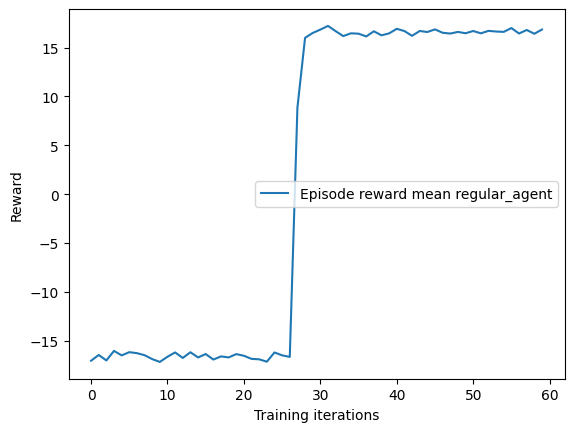

dict_keys(['regular_agent'])


In [ ]:
fig, axs = plt.subplots(1, 1)
for i, group in enumerate(env.group_map.keys()):
    axs.plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs.set_ylabel("Reward")
    axs.legend()
axs.set_xlabel("Training iterations")
plt.show()
print(env.group_map.keys())


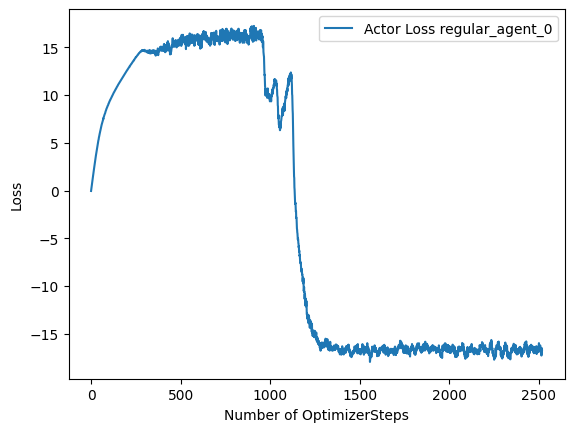

In [ ]:
fig, axs = plt.subplots(1, 1)
for i, group in enumerate(env.possible_agents):
  if group == "regular_agent_0":
    axs.plot(agent_actor_loss[group], label=f"Actor Loss {group}")
    axs.set_ylabel("Loss")
    axs.legend()
axs.set_xlabel("Number of OptimizerSteps")
plt.show()

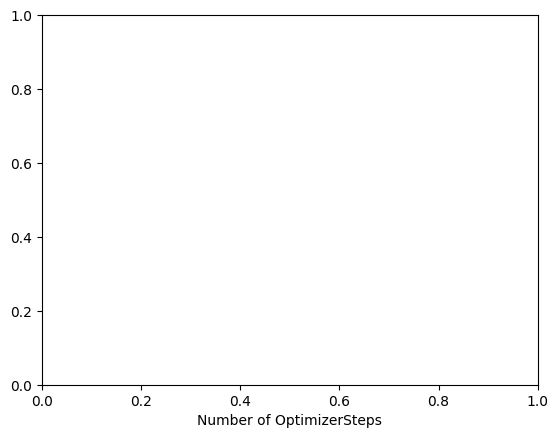

In [ ]:
fig, axs = plt.subplots(1, 1)
for i, group in enumerate(env.possible_agents):
  if group == "cpt_agents_0":
    axs.plot(agent_actor_loss[group], label=f"Actor Loss {group}")
    axs.set_ylabel("Loss")
    axs.legend()
axs.set_xlabel("Number of OptimizerSteps")
plt.show()

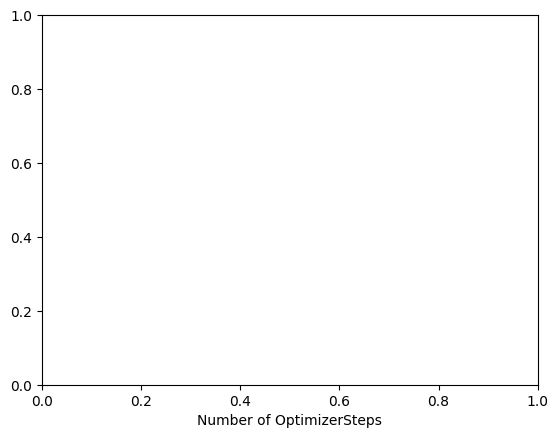

In [ ]:
fig, axs = plt.subplots(1, 1)
for i, group in enumerate(env.possible_agents):
  if group == "cpt_agents_0":
    axs.plot(agent_phi_hist[group], label=f"Phi (CPT Integral) {group}")
    axs.set_ylabel("Phi")
    axs.legend()
axs.set_xlabel("Number of OptimizerSteps")
plt.show()

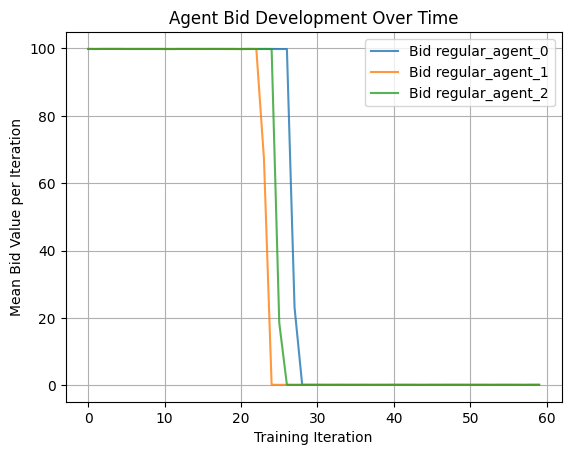

In [ ]:
fig, ax = plt.subplots(1, 1)
for agent in env.possible_agents:
    bids_to_plot = [b for b in agent_bid_hist[agent] if not np.isnan(b)]
    if bids_to_plot:
        ax.plot(bids_to_plot, label=f"Bid {agent}", alpha=0.8)
ax.set_ylabel("Mean Bid Value per Iteration")
ax.set_xlabel("Training Iteration")
ax.legend()
plt.title("Agent Bid Development Over Time")
plt.grid(True)
plt.show()

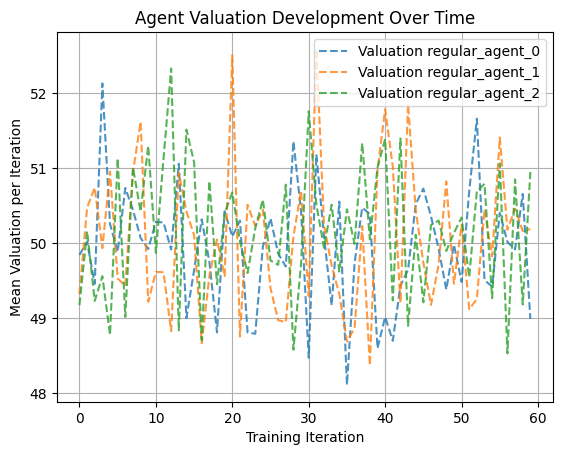

In [ ]:
fig, ax = plt.subplots(1, 1)
for agent in env.possible_agents:
    # Ensure there's data to plot
    vals_to_plot = [v for v in agent_valuation_hist[agent] if not np.isnan(v)]
    if vals_to_plot:
        ax.plot(vals_to_plot, label=f"Valuation {agent}", alpha=0.8, linestyle='--') # Use dashed line for valuation
ax.set_ylabel("Mean Valuation per Iteration")
ax.set_xlabel("Training Iteration")
ax.legend()
plt.title("Agent Valuation Development Over Time")
plt.grid(True)
plt.show()
# --- End Valuation Development Plot ---


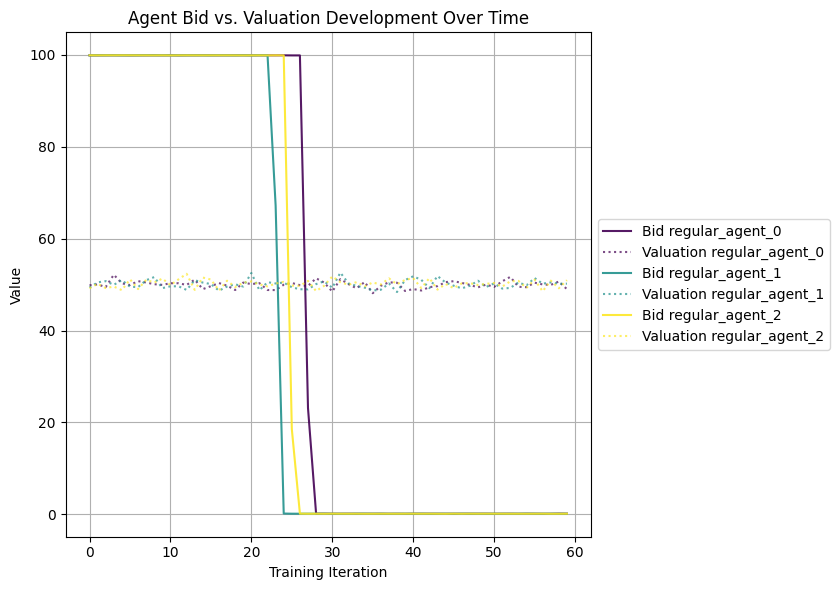

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(env.possible_agents))) # Get distinct colors

for i, agent in enumerate(env.possible_agents):
    # Plot bids
    bids_to_plot = [b for b in agent_bid_hist[agent] if not np.isnan(b)]
    if bids_to_plot:
        ax.plot(bids_to_plot, label=f"Bid {agent}", alpha=0.9, color=colors[i], linestyle='-')

    # Plot valuations
    vals_to_plot = [v for v in agent_valuation_hist[agent] if not np.isnan(v)]
    if vals_to_plot:
        ax.plot(vals_to_plot, label=f"Valuation {agent}", alpha=0.7, color=colors[i], linestyle=':') # Dashed/dotted line

ax.set_ylabel("Value")
ax.set_xlabel("Training Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Move legend outside plot
plt.title("Agent Bid vs. Valuation Development Over Time")
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

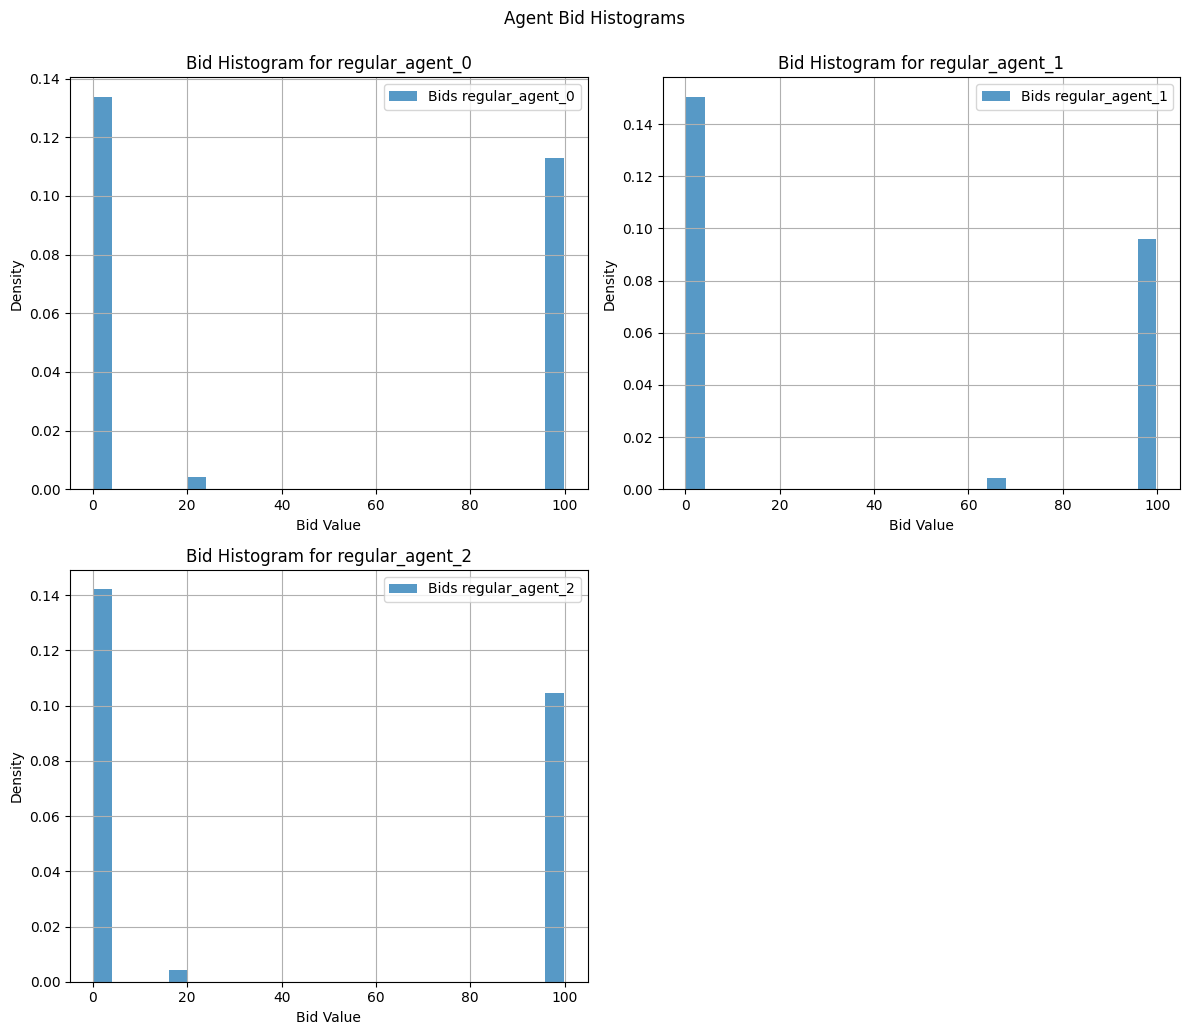

In [ ]:
n_agents_total = len(env.possible_agents)
ncols = min(n_agents_total, 2) # Adjust grid layout if needed
nrows = (n_agents_total + ncols - 1) // ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)
axs_flat = axs.flatten()
plot_count = 0
for i, agent in enumerate(env.possible_agents):
    bids_to_plot = [b for b in agent_bid_hist[agent] if not np.isnan(b)]
    if bids_to_plot:
        ax = axs_flat[plot_count]
        ax.hist(bids_to_plot, bins=25, alpha=0.75, label=f"Bids {agent}", density=True) # Use density=True for comparison
        ax.set_xlabel("Bid Value")
        ax.set_ylabel("Density")
        ax.set_title(f"Bid Histogram for {agent}")
        ax.legend()
        ax.grid(True)
        plot_count += 1
    else:
         print(f"No valid bid data to plot histogram for agent {agent}.")
# Hide unused subplots
for j in range(plot_count, len(axs_flat)):
    axs_flat[j].set_visible(False)
plt.tight_layout()
plt.suptitle("Agent Bid Histograms", y=1.03)
plt.show()

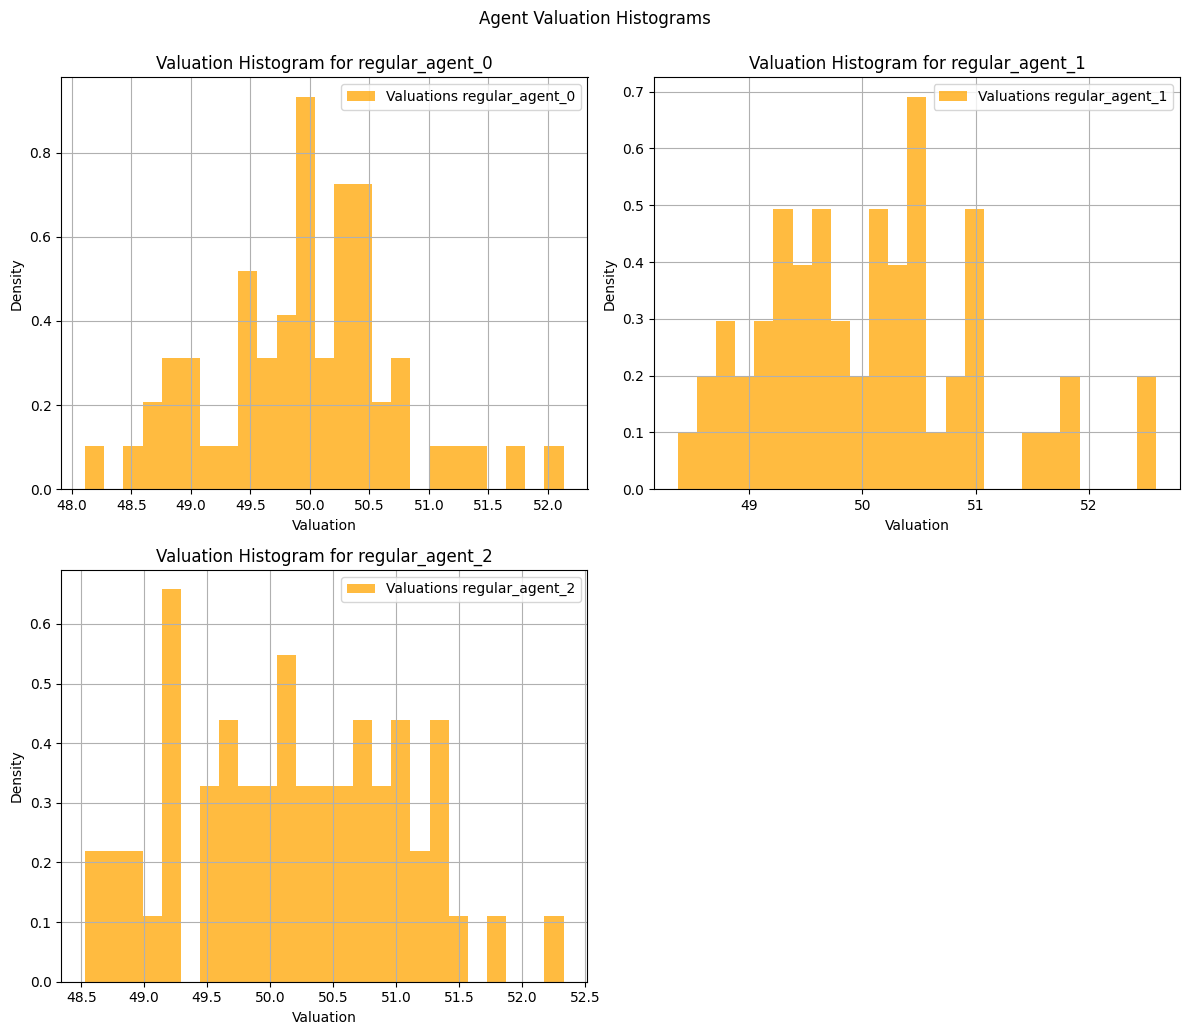

In [ ]:
fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False) # Use same layout as bids
axs_flat = axs.flatten()
plot_count = 0
for i, agent in enumerate(env.possible_agents):
    vals_to_plot = [v for v in agent_valuation_hist[agent] if not np.isnan(v)]
    if vals_to_plot:
        ax = axs_flat[plot_count]
        # Since valuations are U[0, 100], a histogram is meaningful
        ax.hist(vals_to_plot, bins=25, alpha=0.75, label=f"Valuations {agent}", color='orange', density=True)
        ax.set_xlabel("Valuation")
        ax.set_ylabel("Density")
        ax.set_title(f"Valuation Histogram for {agent}")
        ax.legend()
        ax.grid(True)
        plot_count += 1
    else:
         print(f"No valid valuation data to plot histogram for agent {agent}.")
# Hide unused subplots
for j in range(plot_count, len(axs_flat)):
    axs_flat[j].set_visible(False)
plt.tight_layout()
plt.suptitle("Agent Valuation Histograms", y=1.03) # Add overall title
plt.show()